In [3]:
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt

# The Data

In [20]:
#Download Sp500 Data
SPX = web.DataReader(name = '^GSPC',data_source = 'yahoo', start='2000-01-01')
SPX_adj_close = SPX['Adj Close']

Text(0.5, 1.0, 'SPX')

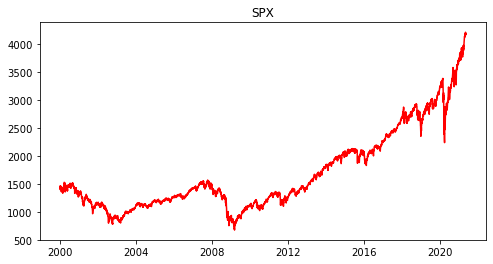

In [21]:
# Plot data
plt.figure(figsize=(8,4))
plt.plot(SPX_adj_close.index, SPX_adj_close.values, color='red')
plt.title('SPX')

# Volatility Estimation

### Close to Close Volatility

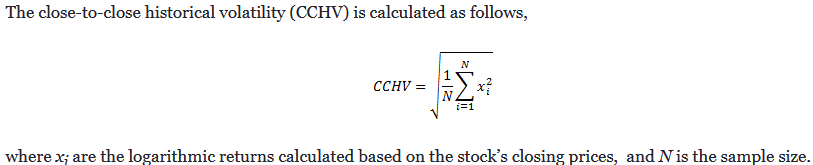

C:\Users\Rantanplan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


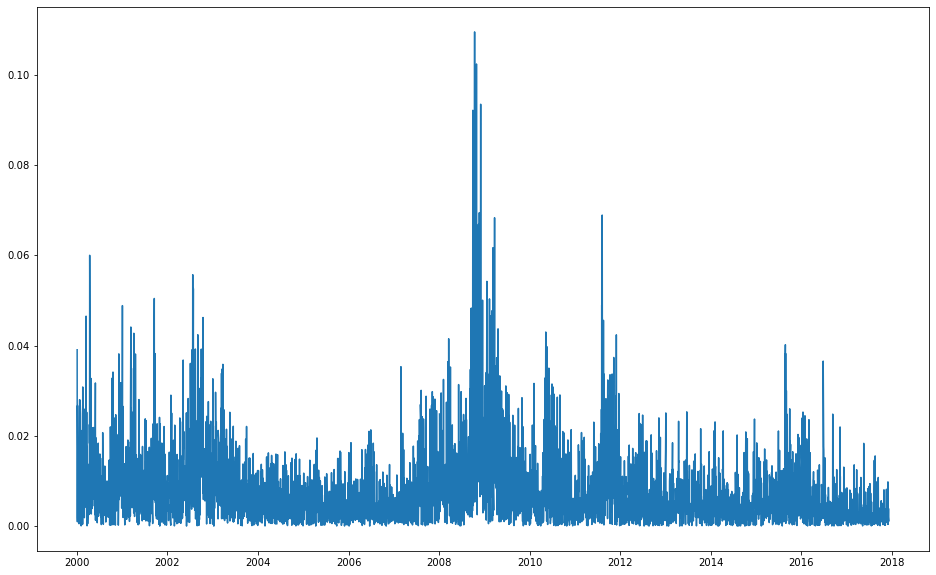

In [156]:
def close_to_close_vol(SPX):
    
    window =1
    log_returns = np.log(SPX.loc[:, "Adj Close"]) - np.log(SPX.loc[:, "Adj Close"].shift(1))
    
    
    sigma_cc = np.sqrt(1/window * pd.DataFrame.rolling(log_returns**2, window=window).sum())
    return sigma_cc

sigma_cc = close_to_close_vol(SPX)
plt.figure(figsize=(16,10))
plt.plot(sigma_cc.loc["2000-01-03":"2017-12-05"])

### Parkinson Volatility Estimate

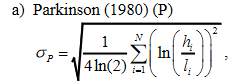

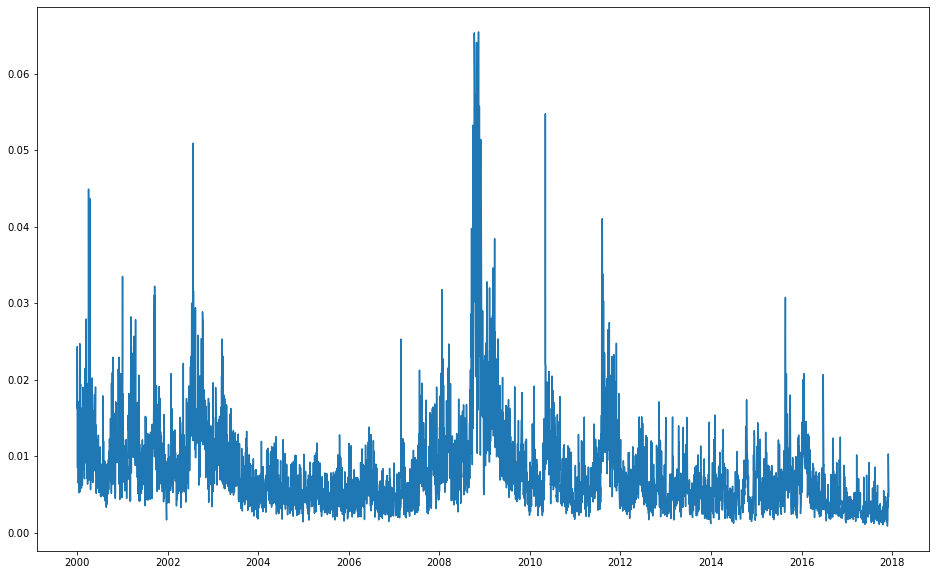

In [167]:
def parkinson_vol(SPX):
    
    sigma_parkinson = np.sqrt(pd.DataFrame.rolling( (1/(4*np.log(2))) *
        np.log(SPX.loc[:, "High"] / SPX.loc[:, "Low"])**2, window=window).sum())
    return sigma_parkinson
sigma_parkinson = parkinson_vol(SPX)
plt.figure(figsize=(16,10))
plt.plot(sigma_parkinson.loc["2000-01-03":"2017-12-05"])

### GK Volatility Estimate

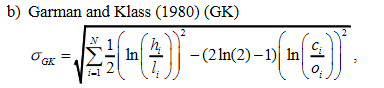

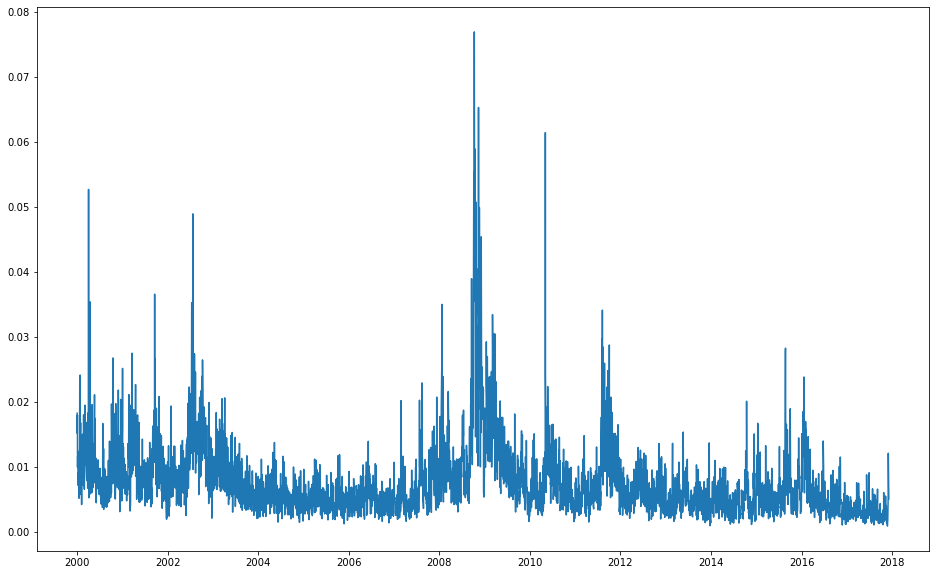

In [170]:
def gk_vol(SPX):
    window = 1
    time_horizon = window
    sigma_gk = np.sqrt((1/window)*time_horizon * 
        pd.DataFrame.rolling(
            (1/2) * np.log(SPX.loc[:, "High"] / SPX.loc[:, "Low"])**2 - (2*np.log(2)-1) * np.log(SPX.loc[:, "Close"] / SPX.loc[:, "Open"])**2, 
            window=window).sum()
    )
    return sigma_gk
sigma_gk = gk_vol(SPX)
plt.figure(figsize=(16,10))
plt.plot(sigma_gk.loc["2000-01-03":"2017-12-05"])

### Rogers and Satchell

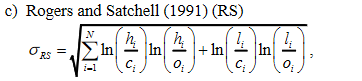

C:\Users\Rantanplan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


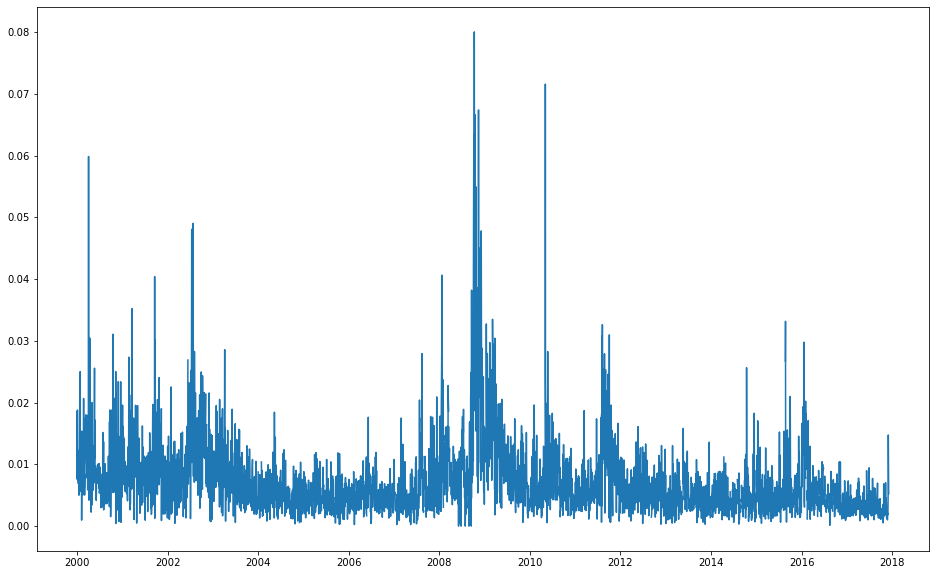

In [196]:
def rs_vol(SPX):
    
    window = 1
    time_horizon = window
    
    sigma_rs = np.sqrt( (1/window)*time_horizon *
        pd.DataFrame.rolling(
            np.log(SPX.loc[:, "High"] / SPX.loc[:, "Close"]) * np.log(SPX.loc[:, "High"] / SPX.loc[:, "Open"]) + np.log(SPX.loc[:, "Low"] / SPX.loc[:, "Close"])* np.log(SPX.loc[:, "Low"] / SPX.loc[:, "Open"]),
        window=window).sum()
    )
    return sigma_rs
sigma_rs = rs_vol(SPX)
plt.figure(figsize=(16,10))
plt.plot(sigma_rs.loc["2000-01-03":"2017-12-05"])

### GKYZ Volatility Estimate

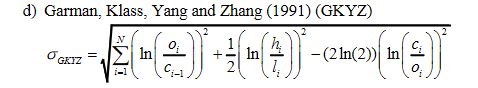

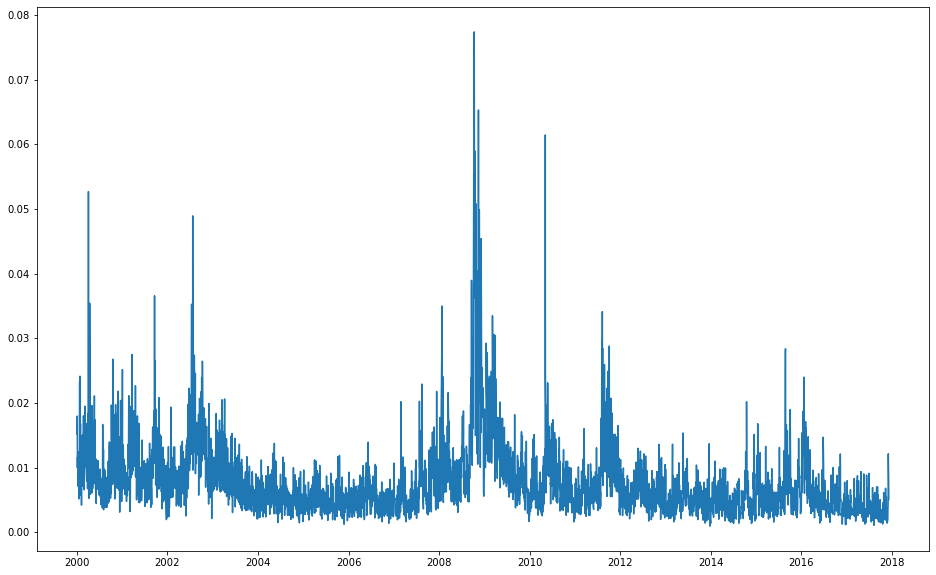

In [213]:
"Missing N from calculations! Paper is wrong?"

def GKYZ_vol(SPX):
    
    # Estimating over total Range
    a_list = list()
    b_list = list()
    c_list = list()

    N = len(SPX) # number of days
    F = 1 # samples per day

    for i in range(len(SPX)):
        try:
            high_t = SPX.iloc[i+1,0]
            low_t = SPX.iloc[i+1,1]

            open_t0 = SPX.iloc[i,2]
            open_t = SPX.iloc[i+1,2]

            close_t0 = SPX.iloc[i,3]
            close_t = SPX.iloc[i+1,3]

            a = np.log(open_t/close_t0)**2
            b = (1/2) * np.log(high_t/low_t)**2
            c = (2 * np.log(2) - 1) * np.log(close_t/open_t)**2

            a_list.append(a)
            b_list.append(b)
            c_list.append(c)
        except IndexError:
            pass

    GKYZHV_daily = np.sqrt(np.sum(a_list) + np.sum(b_list) - np.sum(c_list) ) # Daily vol
    GKYZHV_yearly = GKYZHV_daily * np.sqrt((F * 252)/N)
    
    # Compute Rolling Window of Volatility
    window = 1 # avg num days in a month: 22
    horizon = window # The time horizon of the estimation, yearly_vol=252, monthly_vol=22, daily_vol=1
    
    GKYZHV_roll =  np.sqrt((1/window)*horizon*F * pd.DataFrame.rolling(
                    np.log(SPX.loc[:, "Open"] / SPX.loc[:, "Close"].shift(1))**2 +  # shift here shifts the whole array 1 back (not in front)
                    (1/2) * np.log(SPX.loc[:, "High"] / SPX.loc[:, "Low"])**2 -
                    (2* np.log(2) - 1) * np.log(SPX.loc[:,"Close"] / SPX.loc[:, "Open"])**2, 
                    window=window).sum())
    
    return GKYZHV_daily, GKYZHV_yearly, GKYZHV_roll

GKYZHV_daily, GKYZHV_yearly, GKYZHV_roll = GKYZ_vol(SPX)

plt.figure(figsize=(16,10))
plt.plot(GKYZHV_roll.loc["2000-01-03":"2017-12-05"])
#plt.ylim(0,0.003)

### Yang and Zhang Volatility

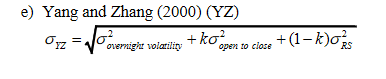

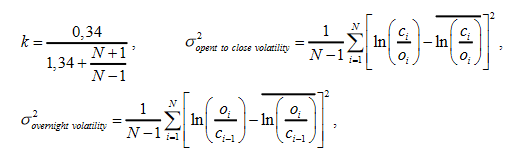

In [202]:
#def yz_vol(SPX):
    
window = 1
N = 2

k = 0.34 / (1.34 + (N+1)/(N-1))

open_to_close_var = 1/(N-1) * pd.DataFrame.rolling(
                                (
                                    np.log(SPX.loc[:, "Close"] / SPX.loc[:, "Open"]) - np.log(SPX.loc[:, "Close"].mean() / SPX.loc[:, "Open"].mean())
                                )**2,
                            window=window).sum()

overnight_var = 1/(N-1) * pd.DataFrame.rolling(
                                (
                                    np.log(SPX.loc[:, "Open"] / SPX.loc[:, "Close"].shift(1)) - np.log(SPX.loc[:, "Open"].mean() / SPX.loc[:, "Close"].shift(1).mean())
                                )**2,
                            window=window).sum()

sigma_rs = rs_vol(SPX)

sigma_yz = np.sqrt(overnight_var + k*open_to_close_var + (1-k)*sigma_rs)
    #return sigma_yz
sigma_yz = yz_vol(SPX)

C:\Users\Rantanplan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


In [206]:
overnight_var[2]+ k*open_to_close_var[2]+ (1-k)*sigma_rs[2]

0.017323606521241267

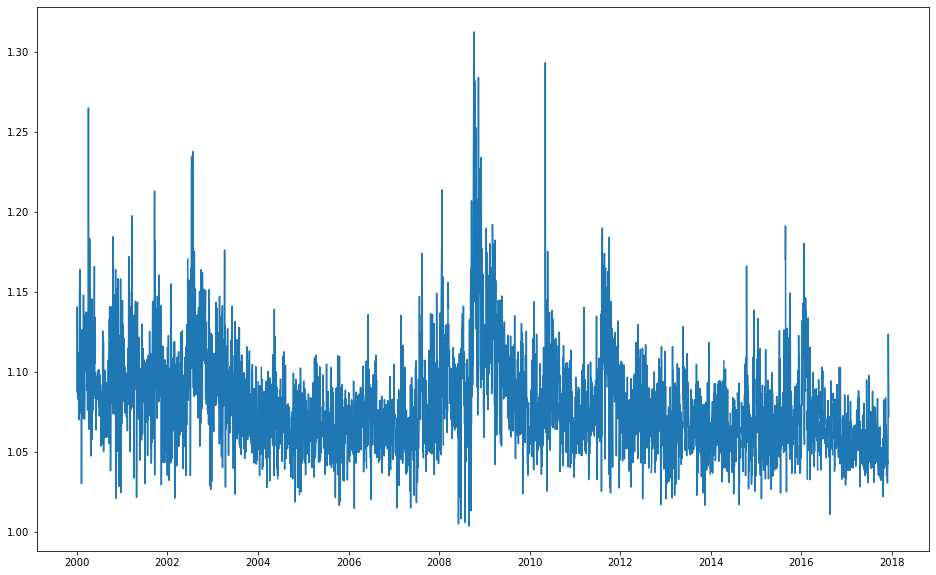

In [214]:
plt.figure(figsize=(16,10))
plt.plot(sigma_yz.loc["2000-01-03":"2017-12-05"])

In [186]:
SPX.loc[:, "Close"].mean()

1689.9398394915218

In [187]:
SPX.loc[:, "Open"].mean()

1689.7172409913064

In [190]:
#pd.DataFrame.rolling(SPX.loc[:, "Open"], window=1).mean()

In [ ]:
#pd.DataFrame.rolling(SPX.loc[:, "Close"], window=1).mean()

In [19]:
#pct_change_vals.dropna()

In [37]:
pct_change_vals = SPX_adj_close.pct_change()
pct_change_vals = pct_change_vals.dropna()

In [24]:
pct_change_vals.index[]

Timestamp('2000-01-03 00:00:00')

In [30]:
import numpy as np

In [32]:
time_t, vol_t

(Timestamp('2000-01-04 00:00:00'), nan)

In [43]:
np.log(-0.006832/0.010671)

C:\Users\Rantanplan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


nan

In [61]:
len(vol_df)

5367

In [67]:
np.log(0)

C:\Users\Rantanplan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


-inf

In [66]:
vol_df.min

Daily Volatilities    0.0
dtype: float64

In [48]:
np.sum(np.log(vol_df))/len(vol_df)

C:\Users\Rantanplan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


Daily Volatilities   NaN
dtype: float64

In [45]:
vol_df = pd.DataFrame() #columns=["Daily Volatilities"]
for i, val in enumerate(pct_change_vals):
    try:
        time_t = pct_change_vals.index[i+1]
        vol_t = (pct_change_vals[i+1]/pct_change_vals[i])**2
        vol_df.loc[time_t, "Daily Volatilities"] = vol_t
        
    except IndexError:
        pass
    

        
    

C:\Users\Rantanplan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """
